In [4]:
from neo4j import GraphDatabase
import pandas as pd
from matplotlib import pyplot as plt
from neo4_connection import USER, PWD, URL
from utils import preprocess_neo4j_db

In [5]:
driver = GraphDatabase.driver(uri=URL, auth=(USER, PWD))

def fetch_data(query):
  with driver.session() as session:
    result = session.run(query)
    return pd.DataFrame([r.values() for r in result], columns=result.keys())

In [6]:
preprocess_neo4j_db(file_path='./neo4j_cypher_queries/01_db_preprocessing.txt')

# About MovieLens

GroupLens Research has collected and made available rating data sets from the MovieLens web site (https://movielens.org). The data sets were collected over various periods of time, depending on the size of the set. 

The dataset consists of users who rated movies. Movies which are in different genres. And persons, such as actors and directors who played or directed the movies. 

<img src="files/MovieLensGraph.png" width="300" style="display=block; margin:auto"/>

Label | # Instances
--- | ---
:User | 671 
:Movie | 9066
:Actor | 15443
:Director | 4091
:Genre | 20
:RATED | 100004
:ACTED_IN | 35910
:DIRECTED | 10007
:IN_GENRE | 20340

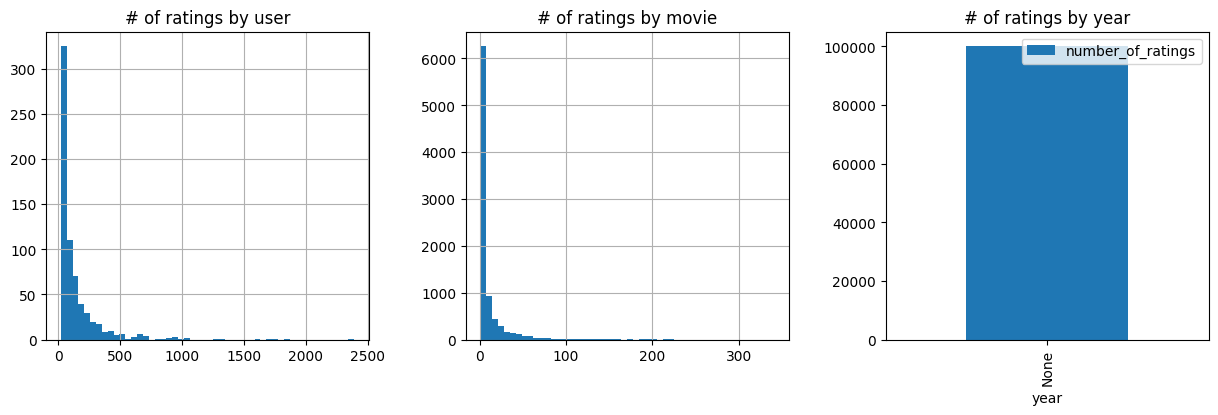

In [7]:
query1 = """
MATCH (u:User) -[r:RATED]-> (m:Movie) 
RETURN u.userId AS user, COUNT(r) AS num_of_ratings
"""

query2 = """
MATCH (u:User) -[r:RATED]-> (m:Movie) 
RETURN m.title AS movie, COUNT(r) AS num_of_ratings
"""

query3 = """
MATCH (u:User) -[r:RATED]-> (m:Movie) 
RETURN r.datetime.year AS year, COUNT(r) AS number_of_ratings
ORDER BY year 
"""

_, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

df = fetch_data(query1)
df.set_index('user', drop=True, inplace=True)
df.hist(bins=50, ax=ax0)

df = fetch_data(query2)
df.set_index('movie', drop=True, inplace=True)
df.hist(bins=50, ax=ax1)

df = fetch_data(query3)
df.plot.bar(x='year', y='number_of_ratings', ax=ax2)

ax0.set_title('# of ratings by user')
ax1.set_title('# of ratings by movie')
ax2.set_title('# of ratings by year')
plt.show()

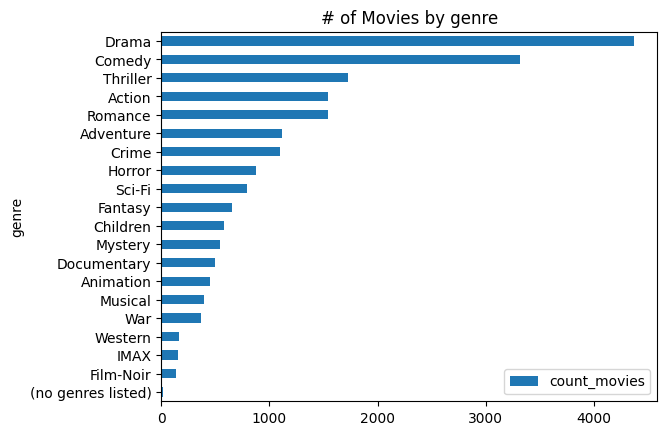

In [8]:
query = """
// How many movies in each genre
MATCH (m:Movie) -[:IN_GENRE]-> (g:Genre)
RETURN g.name AS genre, count(m) AS count_movies
ORDER BY count_movies
"""

df = fetch_data(query)
df.plot.barh(x='genre', y='count_movies')
plt.title('# of Movies by genre')
plt.show()

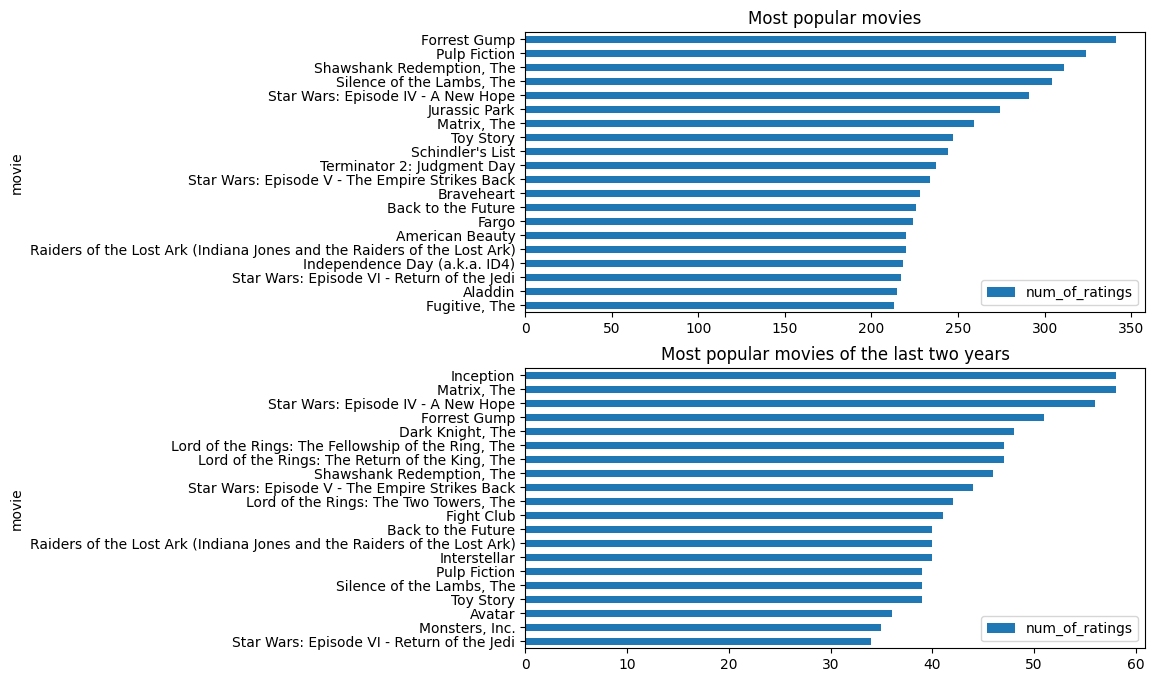

In [9]:
query1 = """
// Most popular movies
MATCH (u:User) -[r:RATED]-> (m:Movie)
RETURN m.title AS movie, count(r) AS num_of_ratings
ORDER BY num_of_ratings DESC
LIMIT 20
"""

query2 = """
// Most popular movies of the last two years
MATCH (u:User) -[r:RATED]-> (m:Movie)
WHERE r.ratingTs.year > 2014
RETURN m.title AS movie, count(r) AS num_of_ratings
ORDER BY num_of_ratings DESC
LIMIT 20
"""

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

df = fetch_data(query1)
df.sort_values(by='num_of_ratings', ascending=True, inplace=True)
df.plot.barh(x='movie', y='num_of_ratings', ax=ax0)

df = fetch_data(query2)
df.sort_values(by='num_of_ratings', ascending=True, inplace=True)
df.plot.barh(x='movie', y='num_of_ratings', ax=ax1)

ax0.set_title('Most popular movies')
ax1.set_title('Most popular movies of the last two years')
plt.show()

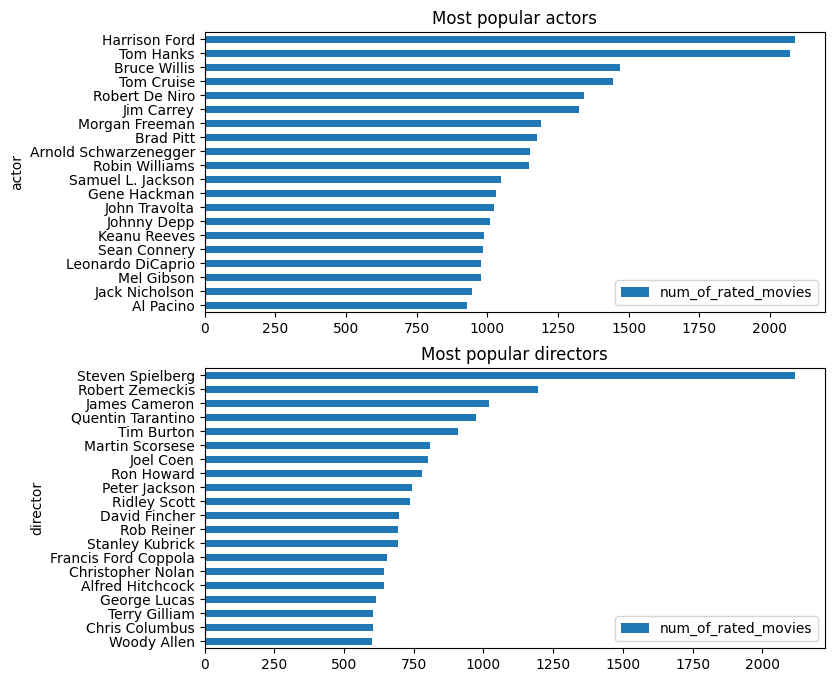

In [10]:
query1 = """
// Most popular actors
MATCH (u:User) -[r:RATED]-> (m:Movie) <-[:ACTED_IN]- (a:Actor)
RETURN a.name AS actor, count(m) AS num_of_rated_movies
ORDER BY num_of_rated_movies DESC
LIMIT 20
"""

query2 = """
// Most popular actors
MATCH (u:User) -[r:RATED]-> (m:Movie) <-[:DIRECTED]- (d:Director)
RETURN d.name AS director, count(m) AS num_of_rated_movies
ORDER BY num_of_rated_movies DESC
LIMIT 20
"""

_, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))

df = fetch_data(query1)
df.sort_values(by='num_of_rated_movies', ascending=True, inplace=True)
df.plot.barh(x='actor', y='num_of_rated_movies', ax=ax0)


df = fetch_data(query2)
df.sort_values(by='num_of_rated_movies', ascending=True, inplace=True)
df.plot.barh(x='director', y='num_of_rated_movies', ax=ax1)

ax0.set_title('Most popular actors')
ax1.set_title('Most popular directors')
plt.show()